<a href="https://colab.research.google.com/github/MatthewK84/Python-Code/blob/main/Energy_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# based on monthly values

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, statsmodels.api as sm, pmdarima as pm
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


import scikeras
from scikeras.wrappers import KerasRegressor

import warnings, calendar

warnings.filterwarnings("ignore")

In [ ]:
data_file = 'continuous_dataset.csv'

df = pd.read_csv(data_file)
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
df.tail()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
48043,2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
48044,2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
48045,2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1
48046,2020-06-26 23:00:00,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1
48047,2020-06-27 00:00:00,1013.5683,26.750330,0.020441,0.063965,10.198346,25.125330,0.019281,0.100189,2.785751,23.562830,0.018404,0.162598,3.286878,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48048 entries, 0 to 48047
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    48048 non-null  object 
 1   nat_demand  48048 non-null  float64
 2   T2M_toc     48048 non-null  float64
 3   QV2M_toc    48048 non-null  float64
 4   TQL_toc     48048 non-null  float64
 5   W2M_toc     48048 non-null  float64
 6   T2M_san     48048 non-null  float64
 7   QV2M_san    48048 non-null  float64
 8   TQL_san     48048 non-null  float64
 9   W2M_san     48048 non-null  float64
 10  T2M_dav     48048 non-null  float64
 11  QV2M_dav    48048 non-null  float64
 12  TQL_dav     48048 non-null  float64
 13  W2M_dav     48048 non-null  float64
 14  Holiday_ID  48048 non-null  int64  
 15  holiday     48048 non-null  int64  
 16  school      48048 non-null  int64  
dtypes: float64(13), int64(3), object(1)
memory usage: 6.2+ MB


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
df.isnull().sum()

datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

##### As can be seen from the first look, the dataset seems to be free from nulls. However, it doesn't start right from 00:00:00 of 1/Jan/2015. hence the paterrn of the first day is exactly repeated for these 2 days as it won't chance things drastically

In [ ]:
start_date = '2015-01-01 00:00:00'
num_hours = 49

# Generate hourly timestamps
hourly_timestamps = pd.date_range(start=start_date, periods=num_hours, freq='H')
df_top_missing = pd.DataFrame()
df_top_missing['datetime'] = hourly_timestamps
for col in df.columns:
    if 'datetime' not in col:
        df_top_missing[col] = df[col][:num_hours]
df_top_missing

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-01 00:00:00,970.3450,25.865259,0.018576,1.617432e-02,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-01 01:00:00,912.1755,25.899255,0.018653,1.641846e-02,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-01 02:00:00,900.2688,25.937280,0.018768,1.548004e-02,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-01 03:00:00,889.9538,25.957544,0.018890,1.627350e-02,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-01 04:00:00,893.6865,25.973840,0.018981,1.728058e-02,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
5,2015-01-01 05:00:00,879.2323,26.034143,0.019080,1.454163e-02,20.062038,22.995081,0.017028,0.001485,9.087273,22.456018,0.016410,0.061539,5.280351,0,0,0
6,2015-01-01 06:00:00,932.4876,26.691492,0.019332,6.645203e-03,21.623496,24.285242,0.017424,0.002176,11.395393,22.949304,0.016570,0.060898,5.126911,0,0,0
7,2015-01-01 07:00:00,1048.9720,27.674066,0.019370,6.862640e-03,23.775317,26.189691,0.018073,0.004539,12.872866,24.088129,0.016677,0.056198,5.060611,0,0,0
8,2015-01-01 08:00:00,1167.9074,28.760400,0.019171,1.023102e-02,24.636152,27.916650,0.018454,0.004292,14.548027,25.479150,0.016646,0.051071,4.915658,0,0,0
9,2015-01-01 09:00:00,1257.5069,29.766656,0.018759,9.017944e-03,25.862671,29.172906,0.018675,0.004921,15.081688,26.704156,0.016608,0.058685,4.685580,0,0,0


In [ ]:
df = pd.concat([df, df_top_missing], axis=0)
df = df.reset_index(drop=True)

df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48097 entries, 0 to 48096
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    48097 non-null  datetime64[ns]
 1   nat_demand  48097 non-null  float64       
 2   T2M_toc     48097 non-null  float64       
 3   QV2M_toc    48097 non-null  float64       
 4   TQL_toc     48097 non-null  float64       
 5   W2M_toc     48097 non-null  float64       
 6   T2M_san     48097 non-null  float64       
 7   QV2M_san    48097 non-null  float64       
 8   TQL_san     48097 non-null  float64       
 9   W2M_san     48097 non-null  float64       
 10  T2M_dav     48097 non-null  float64       
 11  QV2M_dav    48097 non-null  float64       
 12  TQL_dav     48097 non-null  float64       
 13  W2M_dav     48097 non-null  float64       
 14  Holiday_ID  48097 non-null  int64         
 15  holiday     48097 non-null  int64         
 16  school      48097 non-

In [ ]:
df[df['datetime'] == '2020-01-01 00:00:00']

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
43775,2020-01-01,1032.263,25.809259,0.018042,0.032806,14.849625,23.301447,0.017035,0.021866,4.559083,22.598322,0.016195,0.068054,3.737708,1,1,0


## Taking the full years of 2015 to the end of 2019 from the dataset, discarding 2020 as it is a half-year in the dataset

In [ ]:
df = df.loc[:43774]
df.tail()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
43770,2019-12-31 19:00:00,1301.6065,26.635645,0.018421,0.013165,13.184052,25.135645,0.018048,0.064240,3.086798,23.620020,0.016697,0.073425,3.865351,22,1,0
43771,2019-12-31 20:00:00,1250.9634,26.495935,0.018162,0.014713,13.443892,24.769373,0.017781,0.058838,3.659980,23.284998,0.016606,0.064362,4.171572,22,1,0
43772,2019-12-31 21:00:00,1193.6802,26.354456,0.017980,0.013836,13.442195,24.479456,0.017606,0.038086,3.769294,23.041956,0.016492,0.054260,4.045283,22,1,0
43773,2019-12-31 22:00:00,1130.4575,26.166895,0.017965,0.018486,13.420656,24.112207,0.017393,0.020386,3.872397,22.862207,0.016401,0.055557,3.843736,22,1,0
43774,2019-12-31 23:00:00,1084.4737,25.976373,0.018072,0.023315,13.749788,23.663873,0.017156,0.019531,4.165276,22.726373,0.016302,0.061371,3.793209,22,1,0


In [ ]:
abbreviated_month_names = calendar.month_abbr[1:] # ['Jan', 'Feb', ..., 'Dec']
abbreviated_month_dict = {index+1: value for index, value in enumerate(abbreviated_month_names)}

abbreviated_month_dict

{1: 'Jan',
 2: 'Feb',
 3: 'Mar',
 4: 'Apr',
 5: 'May',
 6: 'Jun',
 7: 'Jul',
 8: 'Aug',
 9: 'Sep',
 10: 'Oct',
 11: 'Nov',
 12: 'Dec'}

In [ ]:
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['month_year'] = 0

for i in range(df.shape[0]):
    df['month_year'].iloc[i] = abbreviated_month_dict[df['month'][i]] + '_' + str(df['year'].iloc[i])
df.tail()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,month,year,month_year
43770,2019-12-31 19:00:00,1301.6065,26.635645,0.018421,0.013165,13.184052,25.135645,0.018048,0.064240,3.086798,23.620020,0.016697,0.073425,3.865351,22,1,0,12,2019,Dec_2019
43771,2019-12-31 20:00:00,1250.9634,26.495935,0.018162,0.014713,13.443892,24.769373,0.017781,0.058838,3.659980,23.284998,0.016606,0.064362,4.171572,22,1,0,12,2019,Dec_2019
43772,2019-12-31 21:00:00,1193.6802,26.354456,0.017980,0.013836,13.442195,24.479456,0.017606,0.038086,3.769294,23.041956,0.016492,0.054260,4.045283,22,1,0,12,2019,Dec_2019
43773,2019-12-31 22:00:00,1130.4575,26.166895,0.017965,0.018486,13.420656,24.112207,0.017393,0.020386,3.872397,22.862207,0.016401,0.055557,3.843736,22,1,0,12,2019,Dec_2019
43774,2019-12-31 23:00:00,1084.4737,25.976373,0.018072,0.023315,13.749788,23.663873,0.017156,0.019531,4.165276,22.726373,0.016302,0.061371,3.793209,22,1,0,12,2019,Dec_2019


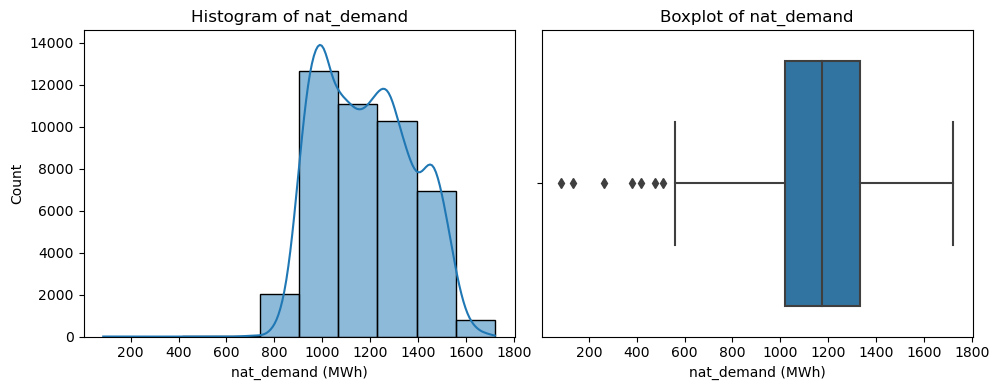

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot a histogram in the first subplot
sns.histplot(df['nat_demand'], bins=10, kde=True, ax=axes[0])
axes[0].set_title('Histogram of nat_demand')
axes[0].set_xlabel('nat_demand (MWh)')

# Plot a boxplot in the second subplot
sns.boxplot(x=df['nat_demand'], ax=axes[1])
axes[1].set_title('Boxplot of nat_demand')
axes[1].set_xlabel('nat_demand (MWh)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
grouped_data_load = df.groupby(['year', 'month'])['nat_demand'].sum()
grouped_data_load

year  month
2015  1        759098.607200
      2        727459.683000
      3        834460.643600
      4        811015.609300
      5        851568.130100
      6        841533.222800
      7        854094.190000
      8        842131.326000
      9        812963.866200
      10       851471.834000
      11       781660.972800
      12       889319.005300
2016  1        852468.934400
      2        794334.281200
      3        868641.892000
      4        876763.725900
      5        880781.806000
      6        842936.252600
      7        844795.620700
      8        875046.204400
      9        833974.281700
      10       857109.082600
      11       777422.265600
      12       860445.715650
2017  1        845740.336100
      2        767648.763961
      3        893618.202009
      4        873982.464500
      5        902108.230300
      6        864588.046727
      7        874028.403500
      8        885409.739300
      9        862227.730700
      10       899725.211800
  

In [ ]:
years = list(df['year'].unique())
years

[2015, 2016, 2017, 2018, 2019]

In [ ]:
start_date = '2015-01-01'

# Create timestamps from 31/Jan/2015 corresponding to the new grouped_data_load
timestamps = pd.date_range(start=start_date, periods=len(grouped_data_load), freq='M')
grouped_data_load = pd.Series(grouped_data_load.values, index=timestamps)
grouped_data_load

2015-01-31    759098.607200
2015-02-28    727459.683000
2015-03-31    834460.643600
2015-04-30    811015.609300
2015-05-31    851568.130100
2015-06-30    841533.222800
2015-07-31    854094.190000
2015-08-31    842131.326000
2015-09-30    812963.866200
2015-10-31    851471.834000
2015-11-30    781660.972800
2015-12-31    889319.005300
2016-01-31    852468.934400
2016-02-29    794334.281200
2016-03-31    868641.892000
2016-04-30    876763.725900
2016-05-31    880781.806000
2016-06-30    842936.252600
2016-07-31    844795.620700
2016-08-31    875046.204400
2016-09-30    833974.281700
2016-10-31    857109.082600
2016-11-30    777422.265600
2016-12-31    860445.715650
2017-01-31    845740.336100
2017-02-28    767648.763961
2017-03-31    893618.202009
2017-04-30    873982.464500
2017-05-31    902108.230300
2017-06-30    864588.046727
2017-07-31    874028.403500
2017-08-31    885409.739300
2017-09-30    862227.730700
2017-10-31    899725.211800
2017-11-30    817646.164700
2017-12-31    870356

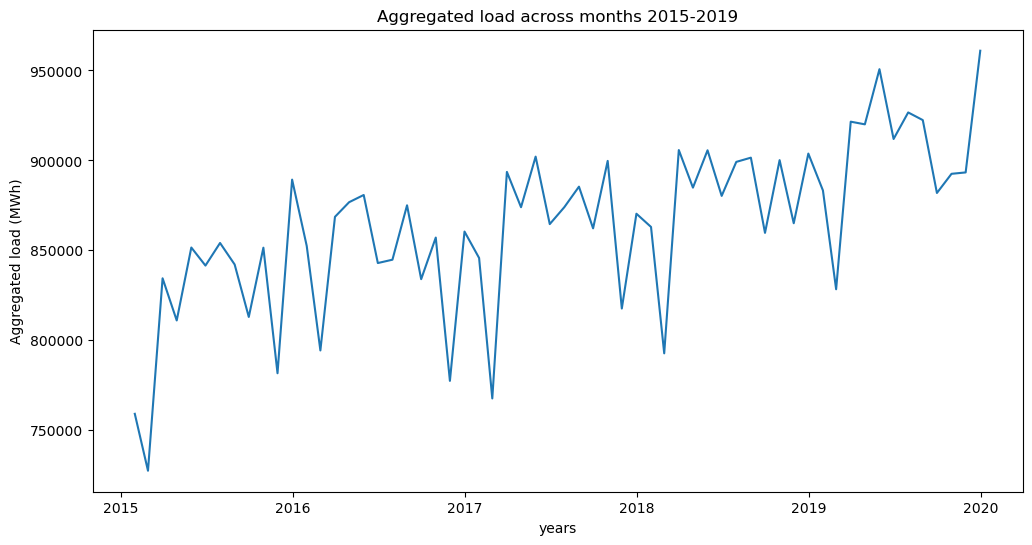

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(grouped_data_load)
plt.title('Aggregated load across months 2015-2019')
plt.xlabel('years')
plt.ylabel('Aggregated load (MWh)')
plt.show()

In [ ]:
df_monthly = pd.DataFrame(index = timestamps)
target_col = 'monthly_demand_TWh'
df_monthly['monthly_demand_TWh'] = grouped_data_load.values
df_monthly['monthly_demand_TWh'] = df_monthly['monthly_demand_TWh'].apply(lambda x: x/1e6)
df_monthly.head()

,monthly_demand_TWh
2015-01-31,0.759099
2015-02-28,0.727460
2015-03-31,0.834461
2015-04-30,0.811016
2015-05-31,0.851568


In [ ]:
weather_cols = ['T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc',
               'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san',
               'T2M_dav', 'QV2M_dav','TQL_dav', 'W2M_dav']

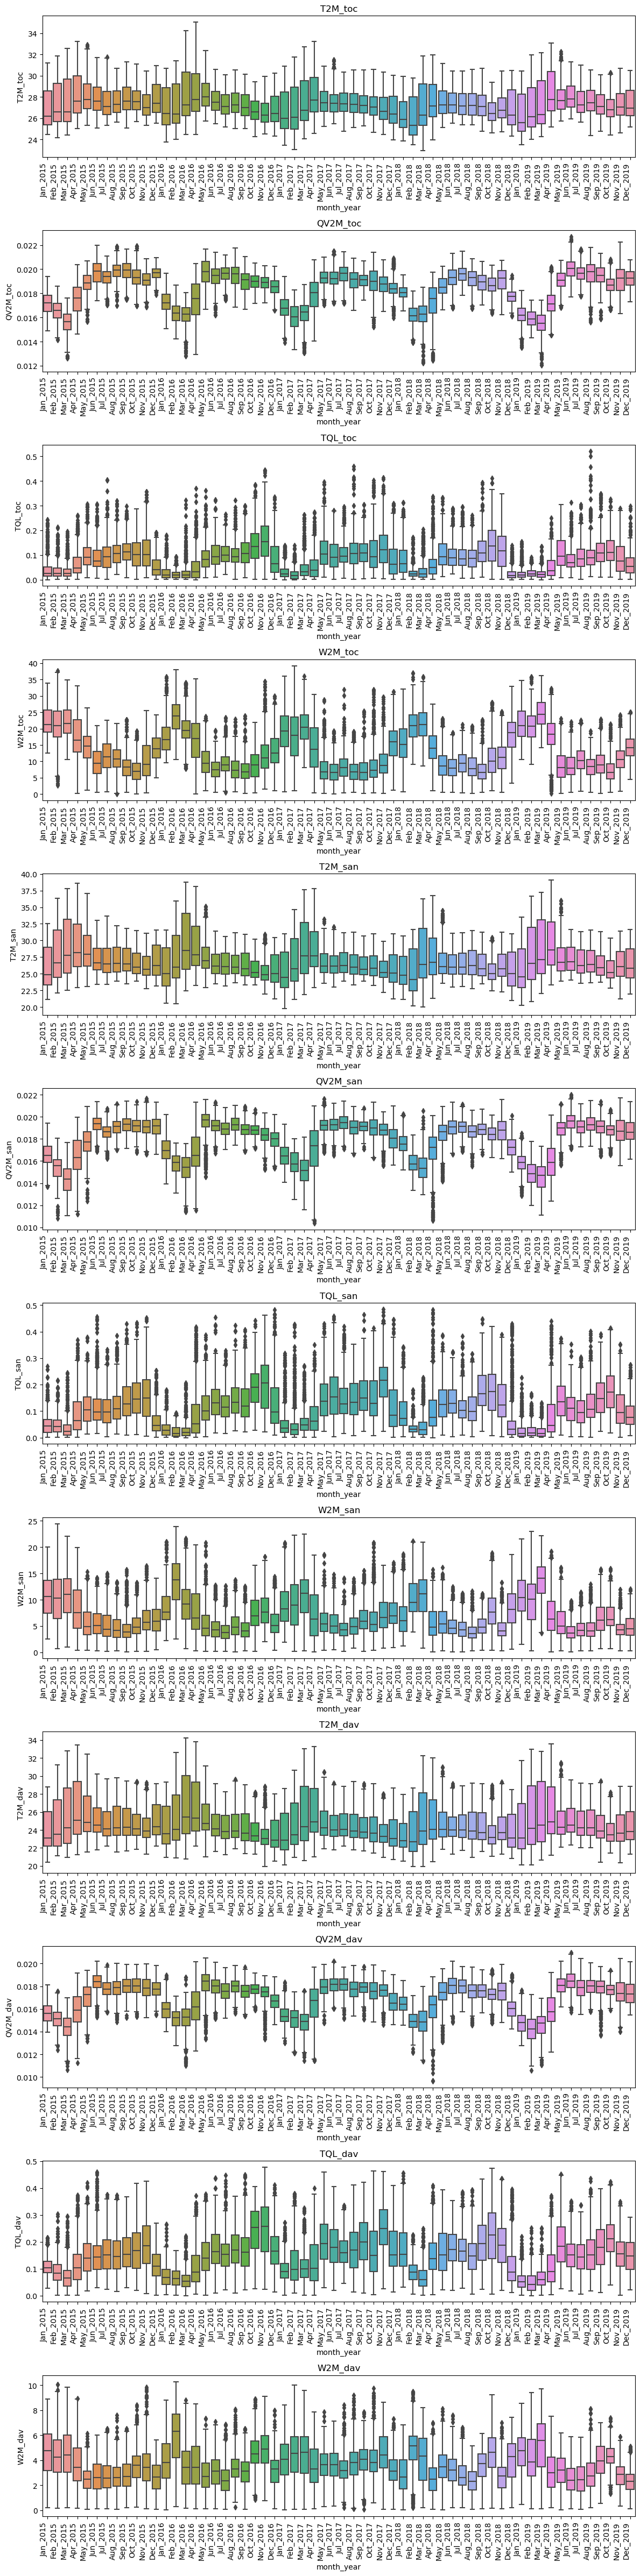

In [ ]:
fig, axes = plt.subplots(nrows=len(weather_cols), ncols=1, figsize=(12, 4*len(weather_cols)))

i=0
for col in weather_cols:
    sns.boxplot(x='month_year', y=df[col], data=df, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xticklabels(df['month_year'].unique(), rotation=90, ha='right') # axes[i].get_xticks()
    i += 1
# Customize the layout
fig.tight_layout()

# Show the plot
plt.show()

#### The above plots show that for every month, the majority of the weather related values are around their mean value. so it's fine to take the mean value and correspond it to the demand values.

In [ ]:
grouped_data_weather = df.groupby(['year', 'month'])[weather_cols].mean()
grouped_data_weather

T2M_toc  QV2M_toc   TQL_toc    W2M_toc    T2M_san  QV2M_san  \
year month                                                                  
2015 1      26.907535  0.017169  0.041728  22.105318  25.967179  0.016577   
     2      27.378773  0.016541  0.037484  20.850716  27.873704  0.015350   
     3      27.591662  0.015600  0.035075  22.051869  28.930676  0.014313   
     4      28.222059  0.017534  0.065823  17.298709  29.270714  0.016388   
     5      28.168494  0.018826  0.098955  14.336817  28.611706  0.017727   
     6      27.877253  0.019694  0.091000   9.840474  27.267335  0.019316   
     7      27.489365  0.019318  0.098257  11.547375  27.144334  0.018636   
     8      27.608635  0.019859  0.108435  10.786627  27.160404  0.019077   
     9      27.845179  0.019800  0.116738   8.362092  27.072306  0.019284   
     10     27.761965  0.019332  0.106921   7.255556  26.592200  0.019162   
     11     27.300845  0.019134  0.114975  10.349001  26.250313  0.019105   
     12     27.853830  0.019683  0.052634  13.977258  26.919302  0.019109   
2016 1      27.024382  0.017369  0.029898  17.449504  25.819703  0.017051   
     2      27.226169  0.016334  0.021440  23.925074  27.339821  0.015706   
     3      28.230120  0.016183  0.028093  19.780636  29.623328  0.015280   
     4      28.408518  0.017435  0.051756  16.385931  29.153418  0.016874   
     5      28.276987  0.019712  0.092269  10.053985  27.547337  0.019396   
     6      27.671572  0.019393  0.103193   7.540179  26.572614  0.019178   
     7      27.310557  0.019592  0.105078   9.377286  26.479533  0.018908   
     8      27.479705  0.019468  0.100717   7.854728  26.435036  0.019327   
     9      27.230082  0.019051  0.115076   7.254736  26.368971  0.018831   
     10     26.778521  0.018957  0.142978   9.041579  25.739868  0.018797   
     11     26.513248  0.018880  0.156721  12.155673  25.342555  0.018393   
     12     26.835867  0.018530  0.087083  13.426337  25.655350  0.017949   
2017 1      26.596966  0.016867  0.032200  18.963979  25.301257  0.016527   
     2      26.762033  0.016042  0.021989  17.899096  26.865863  0.015681   
     3      27.604676  0.016306  0.046272  20.514841  28.754898  0.015114   
     4      28.228777  0.017847  0.053973  14.074479  28.883400  0.016990   
     5      27.599142  0.019292  0.116283   7.690799  26.665853  0.019227   
     6      27.521096  0.019268  0.101538   6.986183  26.496986  0.019280   
     7      27.522118  0.019556  0.104846   8.451534  26.688617  0.019463   
     8      27.459988  0.019075  0.112708   7.128990  26.421996  0.019015   
     9      27.355455  0.019101  0.113551   7.350412  26.212248  0.019129   
     10     27.219076  0.019007  0.109073   8.593563  26.280180  0.018988   
     11     26.952181  0.018734  0.129180   9.768879  25.726812  0.018729   
     12     26.812636  0.018479  0.080918  15.871352  25.664671  0.018066   
2018 1      26.347732  0.018047  0.081387  15.764312  25.453096  0.017612   
     2      26.082549  0.016201  0.028481  20.911990  25.261690  0.015849   
     3      27.045001  0.016210  0.037036  21.030130  27.739694  0.015389   
     4      27.648029  0.017309  0.061810  14.423187  27.694111  0.016819   
     5      27.547865  0.018567  0.107112   9.177929  26.800469  0.018439   
     6      27.474052  0.019271  0.095807   8.214602  26.452252  0.019032   
     7      27.366818  0.019577  0.094739   9.532947  26.483029  0.019072   
     8      27.416052  0.019186  0.088862   8.222473  26.642730  0.018647   
     9      27.296310  0.018911  0.120529   7.067706  26.309808  0.018873   
     10     26.624941  0.018672  0.140398  10.917591  25.466045  0.018429   
     11     27.049451  0.019076  0.123606  11.049368  26.277597  0.018780   
     12     26.896265  0.017760  0.024602  18.052005  25.555897  0.017283   
2019 1      26.370901  0.016238  0.023991  21.521658  25.576693  0.015878   
     2      26.941021  0.015902  0.026155  20.806509  27.845701  0.014868   
     3    

In [ ]:
weather_vars = ['T2M', 'QV2M', 'TQL', 'W2M']

for var in weather_vars:
    new_col = var+'_avg'
    grouped_data_weather[new_col] = 0

for var in weather_vars:
    new_col = var+'_avg'
    toc_col = var+'_toc'
    san_col = var+'_san'
    dav_col = var+'_dav'
    for i in range(grouped_data_weather.shape[0]):
        grouped_data_weather[new_col].iloc[i] = (grouped_data_weather[toc_col].iloc[i] +\
                                                 grouped_data_weather[san_col].iloc[i] +\
                                                 grouped_data_weather[dav_col].iloc[i])/3.

grouped_data_weather

T2M_toc  QV2M_toc   TQL_toc    W2M_toc    T2M_san  QV2M_san  \
year month                                                                  
2015 1      26.907535  0.017169  0.041728  22.105318  25.967179  0.016577   
     2      27.378773  0.016541  0.037484  20.850716  27.873704  0.015350   
     3      27.591662  0.015600  0.035075  22.051869  28.930676  0.014313   
     4      28.222059  0.017534  0.065823  17.298709  29.270714  0.016388   
     5      28.168494  0.018826  0.098955  14.336817  28.611706  0.017727   
     6      27.877253  0.019694  0.091000   9.840474  27.267335  0.019316   
     7      27.489365  0.019318  0.098257  11.547375  27.144334  0.018636   
     8      27.608635  0.019859  0.108435  10.786627  27.160404  0.019077   
     9      27.845179  0.019800  0.116738   8.362092  27.072306  0.019284   
     10     27.761965  0.019332  0.106921   7.255556  26.592200  0.019162   
     11     27.300845  0.019134  0.114975  10.349001  26.250313  0.019105   
     12     27.853830  0.019683  0.052634  13.977258  26.919302  0.019109   
2016 1      27.024382  0.017369  0.029898  17.449504  25.819703  0.017051   
     2      27.226169  0.016334  0.021440  23.925074  27.339821  0.015706   
     3      28.230120  0.016183  0.028093  19.780636  29.623328  0.015280   
     4      28.408518  0.017435  0.051756  16.385931  29.153418  0.016874   
     5      28.276987  0.019712  0.092269  10.053985  27.547337  0.019396   
     6      27.671572  0.019393  0.103193   7.540179  26.572614  0.019178   
     7      27.310557  0.019592  0.105078   9.377286  26.479533  0.018908   
     8      27.479705  0.019468  0.100717   7.854728  26.435036  0.019327   
     9      27.230082  0.019051  0.115076   7.254736  26.368971  0.018831   
     10     26.778521  0.018957  0.142978   9.041579  25.739868  0.018797   
     11     26.513248  0.018880  0.156721  12.155673  25.342555  0.018393   
     12     26.835867  0.018530  0.087083  13.426337  25.655350  0.017949   
2017 1      26.596966  0.016867  0.032200  18.963979  25.301257  0.016527   
     2      26.762033  0.016042  0.021989  17.899096  26.865863  0.015681   
     3      27.604676  0.016306  0.046272  20.514841  28.754898  0.015114   
     4      28.228777  0.017847  0.053973  14.074479  28.883400  0.016990   
     5      27.599142  0.019292  0.116283   7.690799  26.665853  0.019227   
     6      27.521096  0.019268  0.101538   6.986183  26.496986  0.019280   
     7      27.522118  0.019556  0.104846   8.451534  26.688617  0.019463   
     8      27.459988  0.019075  0.112708   7.128990  26.421996  0.019015   
     9      27.355455  0.019101  0.113551   7.350412  26.212248  0.019129   
     10     27.219076  0.019007  0.109073   8.593563  26.280180  0.018988   
     11     26.952181  0.018734  0.129180   9.768879  25.726812  0.018729   
     12     26.812636  0.018479  0.080918  15.871352  25.664671  0.018066   
2018 1      26.347732  0.018047  0.081387  15.764312  25.453096  0.017612   
     2      26.082549  0.016201  0.028481  20.911990  25.261690  0.015849   
     3      27.045001  0.016210  0.037036  21.030130  27.739694  0.015389   
     4      27.648029  0.017309  0.061810  14.423187  27.694111  0.016819   
     5      27.547865  0.018567  0.107112   9.177929  26.800469  0.018439   
     6      27.474052  0.019271  0.095807   8.214602  26.452252  0.019032   
     7      27.366818  0.019577  0.094739   9.532947  26.483029  0.019072   
     8      27.416052  0.019186  0.088862   8.222473  26.642730  0.018647   
     9      27.296310  0.018911  0.120529   7.067706  26.309808  0.018873   
     10     26.624941  0.018672  0.140398  10.917591  25.466045  0.018429   
     11     27.049451  0.019076  0.123606  11.049368  26.277597  0.018780   
     12     26.896265  0.017760  0.024602  18.052005  25.555897  0.017283   
2019 1      26.370901  0.016238  0.023991  21.521658  25.576693  0.015878   
     2      26.941021  0.015902  0.026155  20.806509  27.845701  0.014868   
     3    

#### Comparing the mean value of every weather variable agianst the weather variable in each city

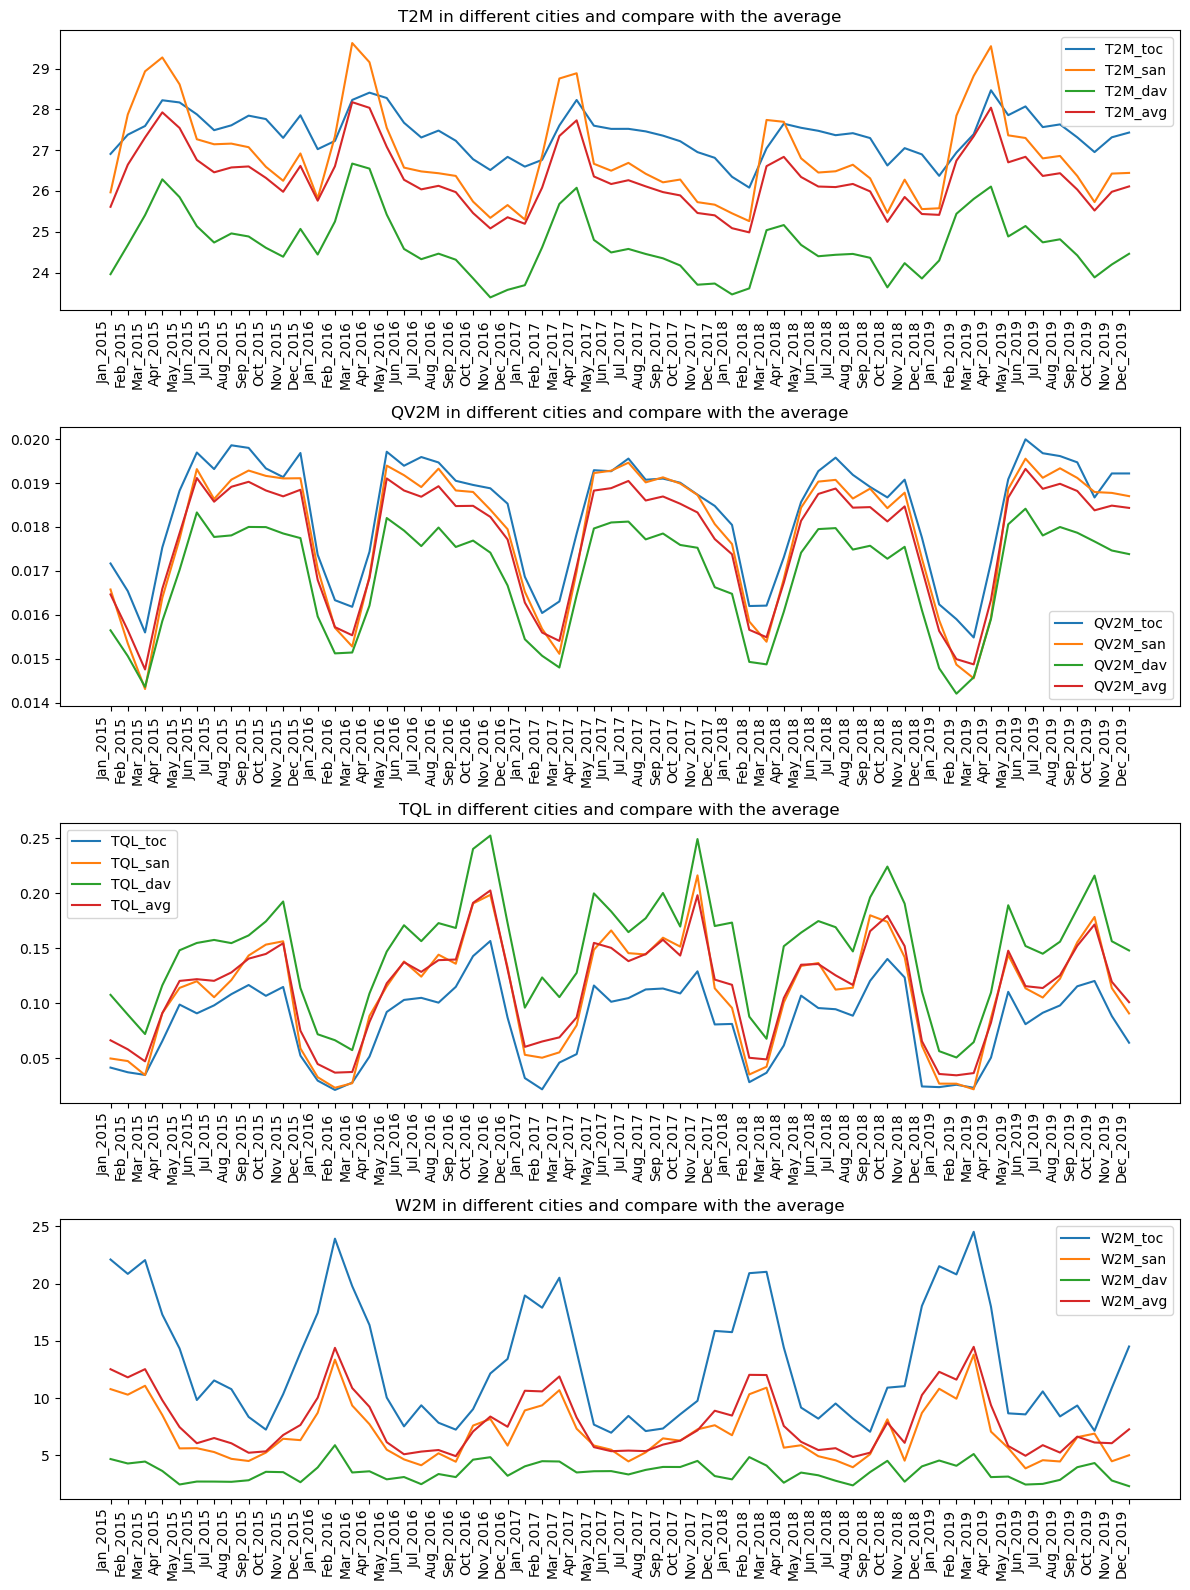

In [ ]:
fig, axes = plt.subplots(nrows=len(weather_vars), ncols=1, figsize=(12, 4*len(weather_vars)))

i=0
for var in weather_vars:
    new_col = var+'_avg'
    toc_col = var+'_toc'
    san_col = var+'_san'
    dav_col = var+'_dav'
    axes[i].plot(df['month_year'].unique(), grouped_data_weather[toc_col].values, label=toc_col)
    axes[i].plot(df['month_year'].unique(), grouped_data_weather[san_col].values, label=san_col)
    axes[i].plot(df['month_year'].unique(), grouped_data_weather[dav_col].values, label=dav_col)
    axes[i].plot(df['month_year'].unique(), grouped_data_weather[new_col].values, label=new_col)
    axes[i].legend()
    title = var + ' in different cities and compare with the average'
    axes[i].set_title(title)
    axes[i].set_xticklabels(df['month_year'].unique(), rotation=90, ha='right')

    i += 1

fig.tight_layout()
# Show the plot
plt.show()

###### As can be seen, the average values of the 3 cities is more or less close to the values of each city, and follows their trend. therefore, it would be fine to take the average value for each weather variable and correspond it to the aggregated demands.

In [ ]:
weather_vars = ['T2M', 'QV2M', 'TQL', 'W2M']
feature_cols = []

for var in weather_vars:
    new_col = var+'_avg'
    feature_cols += [new_col]
    df_monthly[new_col] = list(grouped_data_weather[new_col].values)

df_monthly.head(10)

,monthly_demand_TWh,T2M_avg,QV2M_avg,TQL_avg,W2M_avg
2015-01-31,0.759099,25.612432,0.016465,0.066508,12.528536
2015-02-28,0.727460,26.642825,0.015651,0.058325,11.818067
2015-03-31,0.834461,27.310289,0.014758,0.047409,12.533513
2015-04-30,0.811016,27.926038,0.016594,0.091174,9.823086
2015-05-31,0.851568,27.543151,0.017858,0.120458,7.472603
2015-06-30,0.841533,26.760619,0.019114,0.122035,6.065890
2015-07-31,0.854094,26.457240,0.018575,0.120530,6.521299
2015-08-31,0.842131,26.576482,0.018915,0.128164,6.062768
2015-09-30,0.812964,26.601158,0.019028,0.140674,5.237065
2015-10-31,0.851472,26.321003,0.018831,0.144959,5.358691


In [ ]:
df['Holiday_ID'].unique()

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22,  1], dtype=int64)

#####  this Holiday_ID seems to be categorical with several categories. so we'll one-hot encode it, and then aggregate it by summing up the number of specific holiday_IDs in each month

In [ ]:
df_holiday_id = df[['month', 'year', 'Holiday_ID']]

df_holiday_id.head()

,month,year,Holiday_ID
0,1,2015,0
1,1,2015,0
2,1,2015,0
3,1,2015,0
4,1,2015,0


In [ ]:
df_encoded_holiday_id = pd.get_dummies(df_holiday_id, columns=['Holiday_ID']).astype(int)
df_encoded_holiday_id.head()

,month,year,Holiday_ID_0,Holiday_ID_1,Holiday_ID_2,Holiday_ID_3,Holiday_ID_4,Holiday_ID_5,Holiday_ID_6,Holiday_ID_7,...,Holiday_ID_13,Holiday_ID_14,Holiday_ID_15,Holiday_ID_16,Holiday_ID_17,Holiday_ID_18,Holiday_ID_19,Holiday_ID_20,Holiday_ID_21,Holiday_ID_22
0,1,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
holiday_cols = [col for col in df_encoded_holiday_id.columns if 'Holiday_ID_' in col]
df_encoded_holiday_agg = df_encoded_holiday_id.groupby(['year', 'month'])[holiday_cols].sum()
for col in df_encoded_holiday_agg.columns:
    df_encoded_holiday_agg[col] = df_encoded_holiday_agg[col].apply(lambda x: math.ceil(x/24))

df_encoded_holiday_agg

Holiday_ID_0  Holiday_ID_1  Holiday_ID_2  Holiday_ID_3  \
year month                                                           
2015 1                28             0             1             0   
     2                23             0             0             1   
     3                31             0             0             0   
     4                26             0             0             0   
     5                30             0             0             0   
     6                30             0             0             0   
     7                31             0             0             0   
     8                30             0             0             0   
     9                30             0             0             0   
     10               31             0             0             0   
     11               25             0             0             0   
     12               27             0             0             0   
2016 1                29             1             1             0   
     2                24             0             0             1   
     3                27             0             0             0   
     4                30             0             0             0   
     5                29             0             0             0   
     6                30             0             0             0   
     7                31             0             0             0   
     8                30             0             0             0   
     9                30             0             0             0   
     10               31             0             0             0   
     11               25             0             0             0   
     12               26             0             0             0   
2017 1                28             2             1             0   
     2                24             0             0             1   
     3                30             0             0             0   
     4                26             0             0             0   
     5                30             0             0             0   
     6                30             0             0             0   
     7                31             0             0             0   
     8                30             0             0             0   
     9                30             0             0             0   
     10               31             0             0             0   
     11               24             0             0             0   
     12               27             0             0             0   
2018 1                29             1             1             0   
     2                23             0             0             1   
     3                28             0             0             0   
     4                29             0             0             0   
     5                30             0             0             0   
     6                30             0             0             0   
     7                31             0             0             0   
     8                30             0             0             0   
     9                30             0             0             0   
     10               31             0             0             0   
     11               25             0             0             0   
     12               27             0             0             0   
2019 1                29             1             1             0   
     2                28             0             0             0   
     3                26             0             0             1   
     4                26             0             0             0   
     5                30             0             0             0   
     6                30             0             0             0   
     7                31             0             0             0   
     8                

In [ ]:
for col in df_encoded_holiday_agg.columns:
    df_monthly[col] = df_encoded_holiday_agg[col].values
    feature_cols += [col]

df_monthly.head()

,monthly_demand_TWh,T2M_avg,QV2M_avg,TQL_avg,W2M_avg,Holiday_ID_0,Holiday_ID_1,Holiday_ID_2,Holiday_ID_3,Holiday_ID_4,...,Holiday_ID_13,Holiday_ID_14,Holiday_ID_15,Holiday_ID_16,Holiday_ID_17,Holiday_ID_18,Holiday_ID_19,Holiday_ID_20,Holiday_ID_21,Holiday_ID_22
2015-01-31,0.759099,25.612432,0.016465,0.066508,12.528536,28,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-28,0.727460,26.642825,0.015651,0.058325,11.818067,23,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2015-03-31,0.834461,27.310289,0.014758,0.047409,12.533513,31,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-04-30,0.811016,27.926038,0.016594,0.091174,9.823086,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-05-31,0.851568,27.543151,0.017858,0.120458,7.472603,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### No need to consider the holiday column (of a day) since any kind of holiday along with its frequency has already been considered and one-hot encoded through the Holiday_ID column

In [ ]:
df_school = df.groupby(['year', 'month'])['school'].sum()
df_school = [i/24 for i in list(df_school)]
df_school

[0.0,
 0.0,
 30.0,
 30.0,
 29.0,
 23.0,
 31.0,
 31.0,
 21.0,
 31.0,
 30.0,
 18.0,
 0.0,
 1.0,
 31.0,
 30.0,
 31.0,
 21.0,
 31.0,
 31.0,
 21.0,
 31.0,
 30.0,
 16.0,
 0.0,
 0.0,
 26.0,
 30.0,
 31.0,
 21.0,
 31.0,
 31.0,
 21.0,
 31.0,
 30.0,
 15.0,
 0.0,
 0.0,
 27.0,
 30.0,
 31.0,
 21.0,
 31.0,
 31.0,
 21.0,
 31.0,
 30.0,
 14.0,
 0.0,
 0.0,
 21.0,
 30.0,
 31.0,
 21.0,
 31.0,
 30.0,
 22.0,
 31.0,
 30.0,
 20.0]

In [ ]:
df_monthly['school'] = df_school
feature_cols += ['school']
df_monthly.head(10)

,monthly_demand_TWh,T2M_avg,QV2M_avg,TQL_avg,W2M_avg,Holiday_ID_0,Holiday_ID_1,Holiday_ID_2,Holiday_ID_3,Holiday_ID_4,...,Holiday_ID_14,Holiday_ID_15,Holiday_ID_16,Holiday_ID_17,Holiday_ID_18,Holiday_ID_19,Holiday_ID_20,Holiday_ID_21,Holiday_ID_22,school
2015-01-31,0.759099,25.612432,0.016465,0.066508,12.528536,28,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2015-02-28,0.727460,26.642825,0.015651,0.058325,11.818067,23,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0.0
2015-03-31,0.834461,27.310289,0.014758,0.047409,12.533513,31,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30.0
2015-04-30,0.811016,27.926038,0.016594,0.091174,9.823086,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30.0
2015-05-31,0.851568,27.543151,0.017858,0.120458,7.472603,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29.0
2015-06-30,0.841533,26.760619,0.019114,0.122035,6.065890,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23.0
2015-07-31,0.854094,26.457240,0.018575,0.120530,6.521299,31,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.0
2015-08-31,0.842131,26.576482,0.018915,0.128164,6.062768,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.0
2015-09-30,0.812964,26.601158,0.019028,0.140674,5.237065,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21.0
2015-10-31,0.851472,26.321003,0.018831,0.144959,5.358691,31,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.0


In [ ]:
def decomposition_plot_wrapper(df, col, decompose_type):
    '''
    wrapper around sm.tsa.seasonal_decompose and plotting it
    '''
    decomposition = sm.tsa.seasonal_decompose(df[col], model = decompose_type)
    fig = decomposition.plot()
    plt.show()

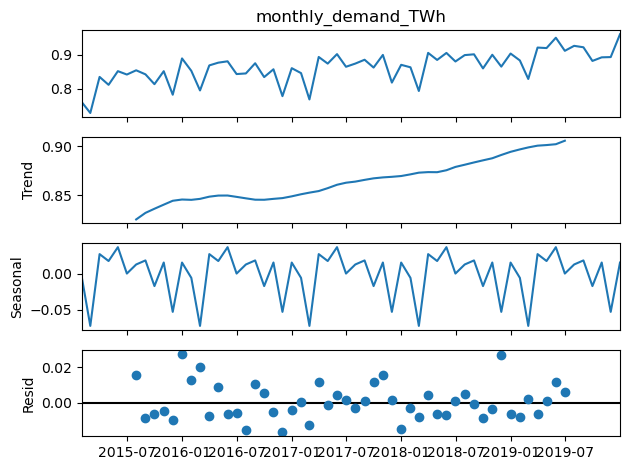

In [ ]:
decomposition_plot_wrapper(df_monthly, 'monthly_demand_TWh', 'additive')

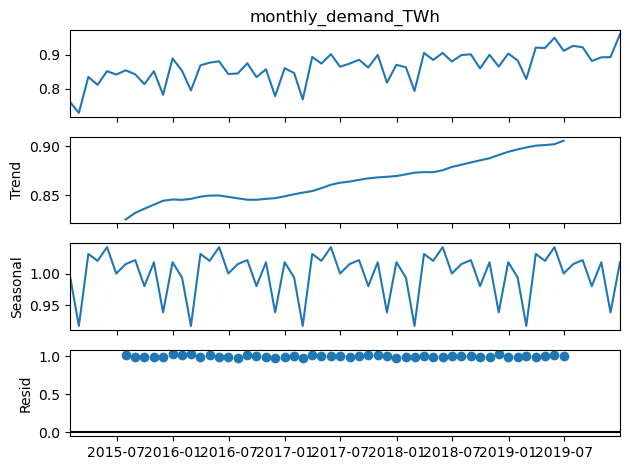

In [ ]:
decomposition_plot_wrapper(df_monthly, 'monthly_demand_TWh', 'multiplicative')

### Stationary test
#### Augmented Dickey-Fuller (ADF) test

In [ ]:
adf_test = adf(df_monthly['monthly_demand_TWh'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: 0.162720
Critical Values @ 0.05: -2.92
p-value: 0.970091


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [ ]:
kpss_test = kpss(df_monthly['monthly_demand_TWh'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.086586
Critical Values @ 0.05: 0.46
p-value: 0.010000


KPSS:  
p-value > 0.05 stationary       p-value <= 0.05 non-stationary
  
ADF:  
p-value > 0.05 non-stationary   p-value <= 0.05 stationary  
  
Our time-series is non-stationary. so we have to make it stationary

### Box Cox transformation to make variance constant

In [ ]:
data_boxcox, lambda_value = boxcox(df_monthly['monthly_demand_TWh'])
data_boxcox = pd.Series(data_boxcox, index = df_monthly.index)

### Differencing to remove trend

In [ ]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), df_monthly.index)
data_boxcox_diff.dropna(inplace=True)

### ADF test

In [ ]:
adf_test = adf(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.220558
Critical Values @ 0.05: -2.93
p-value: 0.018825


### KPSS test

In [ ]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.136143
Critical Values @ 0.05: 0.46
p-value: 0.100000


##### Now the series become stationary!
  
  
### Autocorrelation function (ACF)

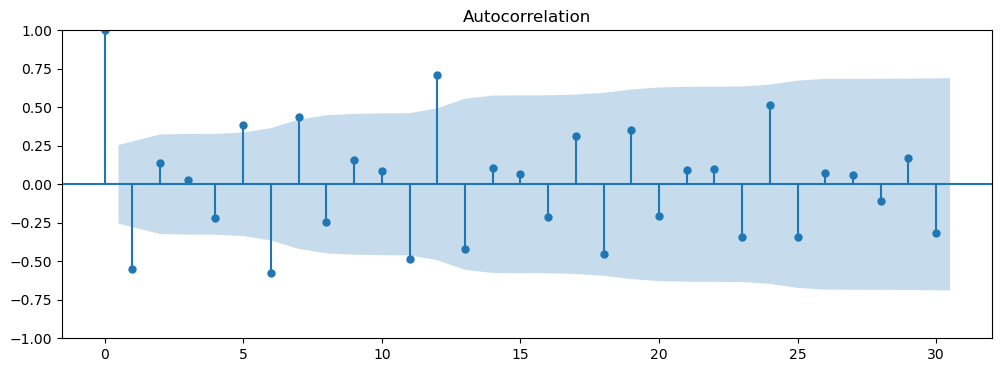

In [ ]:
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

### Partial autocorrelation function (PACF)

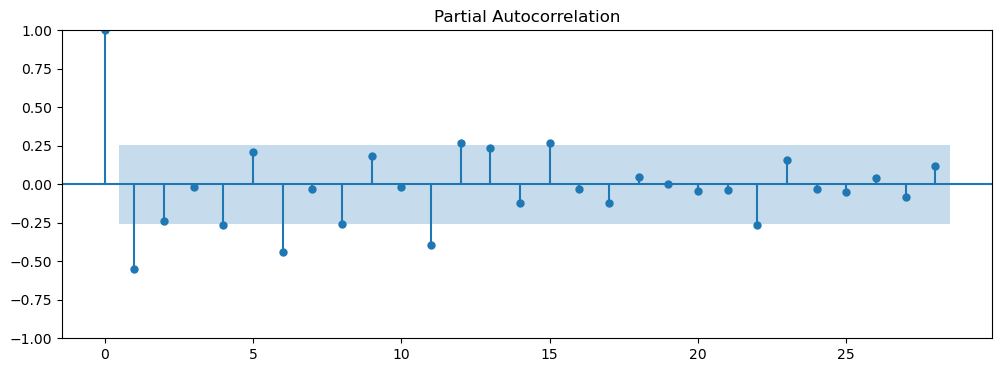

In [ ]:
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 28)
plt.show()

In [ ]:
max_lag = 28
pacf_values, confint = pacf(data_boxcox_diff, nlags=max_lag, alpha=0.05) # alpha=0.05 corresponds to 95% confidence level

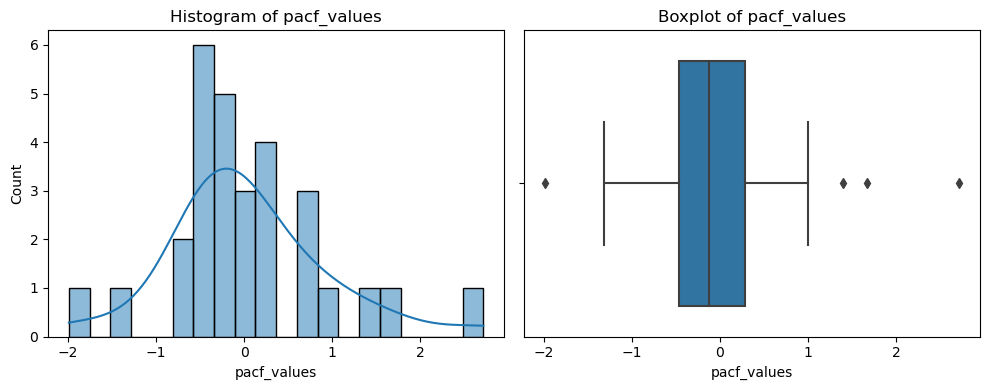

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot a histogram in the first subplot
sns.histplot(pacf_values, bins=20, kde=True, ax=axes[0])
axes[0].set_title('Histogram of pacf_values')
axes[0].set_xlabel('pacf_values')

# Plot a boxplot in the second subplot
sns.boxplot(x=pacf_values, ax=axes[1])
axes[1].set_title('Boxplot of pacf_values')
axes[1].set_xlabel('pacf_values')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
lags = 60
acf_values, confint = acf(data_boxcox_diff, nlags=lags, fft=False, alpha=0.05) # fft: Fast Fourier Transform

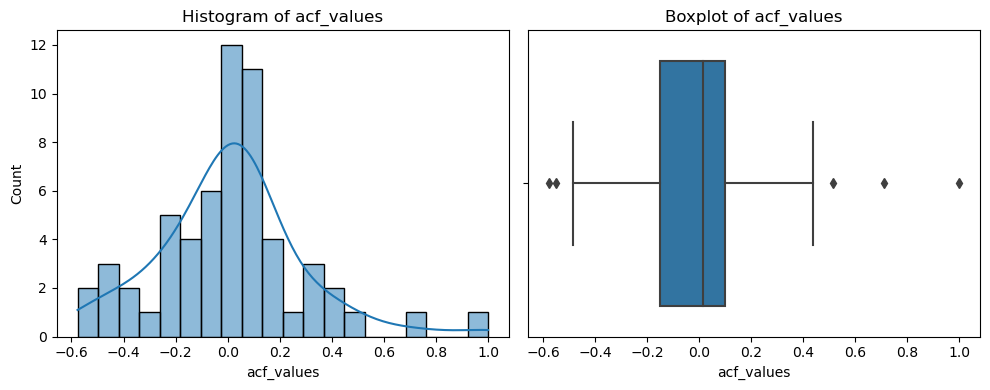

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot a histogram in the first subplot
sns.histplot(acf_values, bins=20, kde=True, ax=axes[0])
axes[0].set_title('Histogram of acf_values')
axes[0].set_xlabel('acf_values')

# Plot a boxplot in the second subplot
sns.boxplot(x=acf_values, ax=axes[1])
axes[1].set_title('Boxplot of acf_values')
axes[1].set_xlabel('acf_values')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

To determine the parameters ‘p’, ‘d’ and ‘q’:  
● For ‘d’: Select d as the order of difference required to make the original time series
stationary. We can verify if this differenced series is stationary or not by using the
stationarity tests: ADF or KPSS test.  
● For ‘p’ and ‘q’: Plot ACF and PACF of the 1st order differenced time series. Find the
value of ‘p’ and ‘q’ as discussed previously with the earlier Auto Regressive Models.  
● The last step in the ARIMA model is to recover the original time series forecast.

In [ ]:
train_len = len(df_monthly)-12
train_len

48

In [ ]:
train_boxcox = data_boxcox[:train_len]

In [ ]:
train_boxcox

2015-01-31   -0.149200
2015-02-28   -0.158796
2015-03-31   -0.118856
2015-04-30   -0.129552
2015-05-31   -0.110250
2015-06-30   -0.115383
2015-07-31   -0.108919
2015-08-31   -0.115084
2015-09-30   -0.128709
2015-10-31   -0.110300
2015-11-30   -0.141300
2015-12-31   -0.088631
2016-01-31   -0.109777
2016-02-29   -0.136441
2016-03-31   -0.100938
2016-04-30   -0.096243
2016-05-31   -0.093854
2016-06-30   -0.114680
2016-07-31   -0.113741
2016-08-31   -0.097250
2016-09-30   -0.119091
2016-10-31   -0.107309
2016-11-30   -0.142855
2016-12-31   -0.105501
2017-01-31   -0.113261
2017-02-28   -0.146315
2017-03-31   -0.085923
2017-04-30   -0.097870
2017-05-31   -0.080420
2017-06-30   -0.103217
2017-07-31   -0.097844
2017-08-31   -0.091048
2017-09-30   -0.104524
2017-10-31   -0.081986
2017-11-30   -0.126650
2017-12-31   -0.099961
2018-01-31   -0.104094
2018-02-28   -0.137075
2018-03-31   -0.077983
2018-04-30   -0.091379
2018-05-31   -0.078071
2018-06-30   -0.094157
2018-07-31   -0.082341
2018-08-31 

In [ ]:
auto_arima_model = pm.auto_arima(train_boxcox, seasonal=True, m=12)

In [ ]:
auto_arima_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 1, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [ ]:
(p, d, q) = auto_arima_model.get_params()['order']

In [ ]:
(P, D, Q, S) = auto_arima_model.get_params()['seasonal_order']

In [ ]:
exog_sarimax_train = df_monthly[feature_cols][:train_len]
exog_sarimax_train

,T2M_avg,QV2M_avg,TQL_avg,W2M_avg,Holiday_ID_0,Holiday_ID_1,Holiday_ID_2,Holiday_ID_3,Holiday_ID_4,Holiday_ID_5,...,Holiday_ID_14,Holiday_ID_15,Holiday_ID_16,Holiday_ID_17,Holiday_ID_18,Holiday_ID_19,Holiday_ID_20,Holiday_ID_21,Holiday_ID_22,school
2015-01-31,25.612432,0.016465,0.066508,12.528536,28,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2015-02-28,26.642825,0.015651,0.058325,11.818067,23,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0.0
2015-03-31,27.310289,0.014758,0.047409,12.533513,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30.0
2015-04-30,27.926038,0.016594,0.091174,9.823086,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30.0
2015-05-31,27.543151,0.017858,0.120458,7.472603,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29.0
2015-06-30,26.760619,0.019114,0.122035,6.065890,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23.0
2015-07-31,26.457240,0.018575,0.120530,6.521299,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.0
2015-08-31,26.576482,0.018915,0.128164,6.062768,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.0
2015-09-30,26.601158,0.019028,0.140674,5.237065,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21.0
2015-10-31,26.321003,0.018831,0.144959,5.358691,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.0


In [ ]:
exog_sarimax_test = df_monthly[feature_cols][train_len:]
exog_sarimax_test

,T2M_avg,QV2M_avg,TQL_avg,W2M_avg,Holiday_ID_0,Holiday_ID_1,Holiday_ID_2,Holiday_ID_3,Holiday_ID_4,Holiday_ID_5,...,Holiday_ID_14,Holiday_ID_15,Holiday_ID_16,Holiday_ID_17,Holiday_ID_18,Holiday_ID_19,Holiday_ID_20,Holiday_ID_21,Holiday_ID_22,school
2019-01-31,25.415137,0.015634,0.035938,12.300301,29,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2019-02-28,26.742879,0.014992,0.034726,11.619606,28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2019-03-31,27.338743,0.014874,0.036749,14.482535,26,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,21.0
2019-04-30,28.040699,0.016342,0.082476,9.394570,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30.0
2019-05-31,26.701968,0.018668,0.147890,5.827357,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.0
2019-06-30,26.837169,0.019321,0.115693,4.973037,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21.0
2019-07-31,26.368540,0.018868,0.114014,5.897809,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.0
2019-08-31,26.435308,0.018982,0.125590,5.250242,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30.0
2019-09-30,26.034661,0.018819,0.152395,6.642768,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22.0
2019-10-31,25.521601,0.018379,0.171689,6.131193,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.0


In [ ]:
model_sarimax = SARIMAX(train_boxcox, order=(p, d, q), seasonal_order=(P, D, Q, S), exog=exog_sarimax_train)
model_sarimax_fit = model_sarimax.fit()
print(model_sarimax_fit.params)

T2M_avg         -7.978702e-04
QV2M_avg         1.534306e+01
TQL_avg         -2.118319e-01
W2M_avg          1.524451e-04
Holiday_ID_0     6.570350e-03
Holiday_ID_1     1.042962e-02
Holiday_ID_2     2.837769e-12
Holiday_ID_3     4.501987e-12
Holiday_ID_4     5.514784e-12
Holiday_ID_5     4.106459e-12
Holiday_ID_6     4.880329e-12
Holiday_ID_7     5.226663e-03
Holiday_ID_8     4.866413e-03
Holiday_ID_9     4.866413e-03
Holiday_ID_10    4.866413e-03
Holiday_ID_11   -6.067245e-04
Holiday_ID_12   -6.088005e-03
Holiday_ID_13   -4.288917e-12
Holiday_ID_14   -1.029017e-11
Holiday_ID_15   -1.029017e-11
Holiday_ID_16    1.017552e-02
Holiday_ID_17   -1.015237e-11
Holiday_ID_18   -1.015237e-11
Holiday_ID_19   -1.516408e-11
Holiday_ID_20   -1.516408e-11
Holiday_ID_21    1.050635e-02
Holiday_ID_22   -1.480472e-11
school          -9.061315e-04
ar.L1            7.203601e-01
ma.S.L12         1.380019e-02
sigma2           3.830852e-05
dtype: float64


#### Recover original time series forecast

In [ ]:
y_hat_sarimax = data_boxcox_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_sarimax_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max(), exog=exog_sarimax_test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

#### Plot train, test and forecast

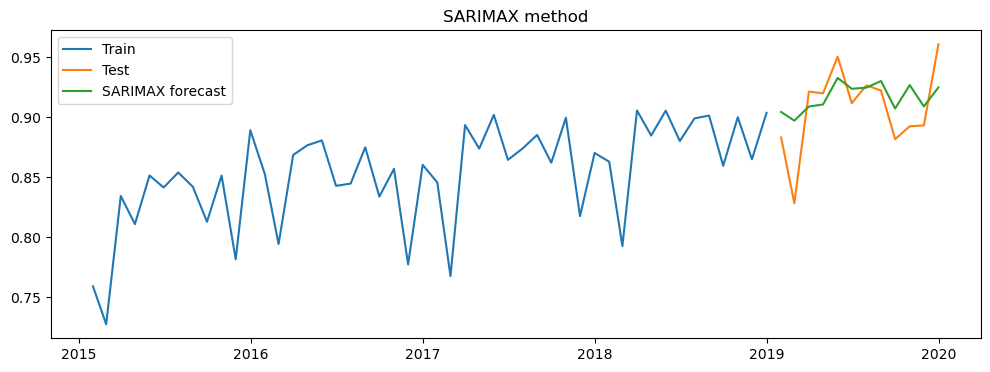

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df_monthly[target_col][:train_len], label='Train')
plt.plot(df_monthly[target_col][train_len:], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][-12:], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX method')
plt.show()

# LSTM

In [ ]:
df_monthly = df_monthly[feature_cols + [target_col]]
df_monthly.head()

,T2M_avg,QV2M_avg,TQL_avg,W2M_avg,Holiday_ID_0,Holiday_ID_1,Holiday_ID_2,Holiday_ID_3,Holiday_ID_4,Holiday_ID_5,...,Holiday_ID_15,Holiday_ID_16,Holiday_ID_17,Holiday_ID_18,Holiday_ID_19,Holiday_ID_20,Holiday_ID_21,Holiday_ID_22,school,monthly_demand_TWh
2015-01-31,25.612432,0.016465,0.066508,12.528536,28,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.759099
2015-02-28,26.642825,0.015651,0.058325,11.818067,23,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0.0,0.727460
2015-03-31,27.310289,0.014758,0.047409,12.533513,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30.0,0.834461
2015-04-30,27.926038,0.016594,0.091174,9.823086,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30.0,0.811016
2015-05-31,27.543151,0.017858,0.120458,7.472603,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29.0,0.851568


In [ ]:
train_len

48

In [ ]:
#train_len = 48 # Already defined ??

# Split the data into training and testing sets
df_train = df_monthly.iloc[:train_len]
df_test = df_monthly.iloc[train_len:]

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train))
df_test_scaled = pd.DataFrame(scaler.fit_transform(df_test))
df_scaled = pd.concat([df_train_scaled, df_test_scaled]).values

df_scaled.shape

(60, 29)

In [ ]:
df_monthly.shape

(60, 29)

In [ ]:
# Convert the time series data into sequences suitable for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps, :-1])  # Exclude the target column for X
        y.append(data[i+n_steps, -1])  # Use the target column for y
    return np.array(X), np.array(y)

# Choose the number of time steps (lookback)
n_steps = 12

# Create sequences for training and testing
x_sc_seq, y_sc_seq = create_sequences(df_scaled, n_steps)

In [ ]:
# slicing the outcome to get train and test sets
train_len_final = train_len - n_steps

x_sc_seq_train = x_sc_seq[:train_len_final, :, :]
x_sc_seq_test = x_sc_seq[train_len_final:, :, :]

y_sc_seq_train = y_sc_seq[:train_len_final]
y_sc_seq_test = y_sc_seq[train_len_final:]

In [ ]:
# Create LSTM model
#model = Sequential()
#model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, len(feature_cols))))
#model.add(Dense(units=1))  # Output layer with 1 neuron for regression
#model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model on the training data
#model.fit(x_sc_seq_train, y_sc_seq_train, epochs=50, batch_size=8)

In [ ]:
# Create another LSTM model
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(n_steps, len(feature_cols)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20, activation='relu', return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(units=1))  # Output layer with 1 neuron for regression
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model on the training data
model.fit(x_sc_seq_train, y_sc_seq_train, epochs=200, batch_size=8)

Epoch 1/200
5/5 [==============================] - 8s 27ms/step - loss: 0.5934
Epoch 2/200
5/5 [==============================] - 0s 24ms/step - loss: 0.4941
Epoch 3/200
5/5 [==============================] - 0s 24ms/step - loss: 0.2137
Epoch 4/200
5/5 [==============================] - 0s 24ms/step - loss: 0.2219
Epoch 5/200
5/5 [==============================] - 0s 27ms/step - loss: 0.1668
Epoch 6/200
5/5 [==============================] - 0s 27ms/step - loss: 0.2013
Epoch 7/200
5/5 [==============================] - 0s 29ms/step - loss: 0.1748
Epoch 8/200
5/5 [==============================] - 0s 28ms/step - loss: 0.1187
Epoch 9/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0557
Epoch 10/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0591
Epoch 11/200
5/5 [==============================] - 0s 28ms/step - loss: 0.0492
Epoch 12/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0472
Epoch 13/200
5/5 [==============================]

5/5 [==============================] - 0s 25ms/step - loss: 0.0079
Epoch 104/200
5/5 [==============================] - 0s 28ms/step - loss: 0.0051
Epoch 105/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0114
Epoch 106/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0076
Epoch 107/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0099
Epoch 108/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0141
Epoch 109/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0137
Epoch 110/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0128
Epoch 111/200
5/5 [==============================] - 0s 28ms/step - loss: 0.0101
Epoch 112/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0097
Epoch 113/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0099
Epoch 114/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0054
Epoch 115/200
5/5 [=======================

In [ ]:
# Make predictions on the test set
pred_sc_seq = model.predict(x_sc_seq_test)
pred_sc_seq_reshaped = pred_sc_seq.reshape(12,)

1/1 [==============================] - 1s 1s/step


In [ ]:
def get_scaler_inverse(vec, scaler, col_num):
    max_value = scaler.data_max_[col_num]
    min_value = scaler.data_min_[col_num]
    output = []
    for i in range(len(vec)):
        calc = vec[i] * (max_value-min_value) + min_value
        output.append(calc)
    return output

lstm_pred = get_scaler_inverse(pred_sc_seq_reshaped, scaler, -1)
lstm_pred

[0.9407453934247503,
 0.884649419544097,
 0.9405963776348185,
 0.9312902233623749,
 0.9464994552530596,
 0.9235121588561961,
 0.9303143829987252,
 0.9376248372368323,
 0.9220854684491367,
 0.9381010410729265,
 0.8677238062499889,
 0.932086065237767]

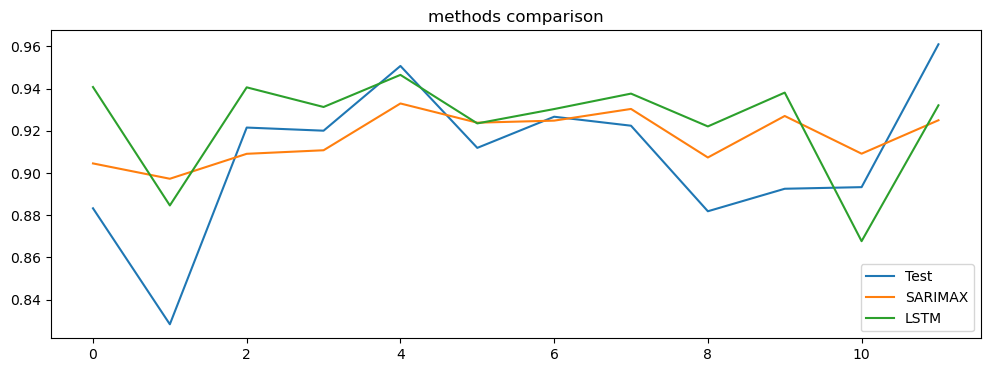

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(list(df_monthly[target_col][train_len:]), label='Test')
plt.plot(list(y_hat_sarimax['sarimax_forecast'][-12:]), label='SARIMAX')
plt.plot(lstm_pred, label='LSTM')
plt.legend(loc='best')
plt.title('methods comparison')
plt.show()

In [ ]:
def metrics_calc(ref, calc):
    ref = np.array(ref)
    calc = np.array(calc)
    rmse = np.sqrt(mean_squared_error(ref, calc)).round(2)
    mape = np.round(np.mean(np.abs(ref-calc)/ref)*100,2)
    return rmse, mape

In [ ]:
ref = list(df_monthly[target_col][train_len:])
sarimax = list(y_hat_sarimax['sarimax_forecast'][-12:])

In [ ]:
method = ['sarimax', 'LSTM']
rmse = [metrics_calc(ref, sarimax)[0], metrics_calc(ref, lstm_pred)[0]]
mape = [metrics_calc(ref, sarimax)[1], metrics_calc(ref, lstm_pred)[1]]
metrics_df = pd.DataFrame(zip(method, rmse, mape), columns=['mthod', 'RMSE', 'MAPE(%)'])
metrics_df

,mthod,RMSE,MAPE(%)
0,sarimax,0.03,2.47
1,LSTM,0.03,2.99
